In [1]:
!pip install --user pandas matplotlib seaborn scikit-learn

In [2]:
from datetime import timedelta
import glob
import re
import math
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from matplotlib.ticker import ScalarFormatter
from matplotlib.ticker import FuncFormatter

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

def load_data(maestro_pattern, vanilla_pattern):
    dfs_maestro = []
    dfs_vanilla = []
    max_groups = 0
    min_groups = 1000
    min_timestamp_maestro = math.inf
    min_timestamp_vanilla = math.inf
    
    # 60 minutes in milliseconds
    MAX_DURATION_MS = 60 * 60 * 1000  # 3,600,000 ms
    
    
    for maestro_file in glob.glob(maestro_pattern):
        match = re.search(r'(\d+)(?!.*\d)', maestro_file)
        i = 0
        if match:
            i = int(match.group(1))
            max_groups = max(i, max_groups)
            min_groups = min(i, min_groups)
        df_maestro = pd.read_csv(maestro_file, sep=' ', header=None, names=['Timestamp', 'Value'])
        min_timestamp_maestro = min(df_maestro['Timestamp'].min(), min_timestamp_maestro)
        df_maestro['Timestamp_Index'] = pd.to_datetime(df_maestro['Timestamp'], unit='ms')
        df_maestro['source'] = 'maestro'
        df_maestro['series'] = f'maestro-{i}'

        dfs_maestro.append(df_maestro)

    for df in dfs_maestro:
        df['elapsed_milliseconds'] = df['Timestamp'] - min_timestamp_maestro
        # Truncate data after 60 minutes
        df = df[df['elapsed_milliseconds'] <= MAX_DURATION_MS]

    for vanilla_file in glob.glob(vanilla_pattern):
        match = re.search(r'(\d+)(?!.*\d)', vanilla_file)
        i = 0
        if match:
            i = int(match.group(1))
            max_groups = max(i, max_groups)
            min_groups = min(i, min_groups)
        df_vanilla = pd.read_csv(vanilla_file, sep=' ', header=None, names=['Timestamp', 'Value'])
        min_timestamp_vanilla = min(df_vanilla['Timestamp'].min(), min_timestamp_vanilla)
        df_vanilla['Timestamp_Index'] = pd.to_datetime(df_vanilla['Timestamp'], unit='ms')
        df_vanilla['source'] = 'vanilla'
        df_vanilla['series'] = f'vanilla-{i}'

        dfs_vanilla.append(df_vanilla)

    for df in dfs_vanilla:
        df['elapsed_milliseconds'] = df['Timestamp'] - min_timestamp_vanilla
        # Truncate data after 60 minutes
        df = df[df['elapsed_milliseconds'] <= MAX_DURATION_MS]

    if max_groups == 0 and min_groups == 1000:
        min_groups = 0
        max_groups = 0
    
    return min_groups, max_groups, pd.concat(dfs_vanilla + dfs_maestro, ignore_index=True)

# Create custom color palettes
def create_shades(base_color, min_groups, max_groups):
    """Generate n shades of a base color"""
    n_shades = max_groups - min_groups + 1
    if max_groups > 0:
        if base_color == 'blue':
            colors = sns.light_palette("blue", n_shades+2)[1:-1]  # Skip the lightest and darkest
        else:  # red
            colors = sns.light_palette("red", n_shades+2)[1:-1]
    else:
        if base_color == 'blue':
            colors = [sns.light_palette("blue", 3)[1]]
        else:  # red
            colors = [sns.light_palette("red", 3)[1]]
    return [colors[i] for i in range(0, max_groups - min_groups + 1)]
        

def format_number(x, pos):
    return "{:,.0f}".format(x).replace(",", "X").replace(".", ",").replace("X", ".")

def format_small_number(x, pos):
    return "{:,.2f}".format(x).replace(",", "X").replace(".", ",").replace("X", ".")

def format_number_percent(x, pos):
    return "{:,.2f}".format(x).replace(",", "X").replace(".", ",").replace("X", ".")

def format_memory_usage(x, pos=None):
    """
    Formata um valor de memória em bytes para uma string legível (ex: "2.5GB", "512MB").
    
    Parâmetros:
    x (int/float): Valor em bytes a ser formatado.
    pos (ignorado): Parâmetro opcional para compatibilidade com formatters do matplotlib.
    
    Retorna:
    str: String formatada com unidade apropriada (B, KB, MB, GB, TB).
    """
    # Define os tamanhos e sufixos
    for unit in ['B', 'KB', 'MB', 'GB', 'TB']:
        if abs(x) < 1024.0:
            if unit in ['B']:
                return "{:,.0f} {}".format(x, unit).replace(",", "X").replace(".", ",").replace("X", ".")
            else:
                return "{:,.2f} {}".format(x, unit).replace(",", "X").replace(".", ",").replace("X", ".")
        x /= 1024.0
    return "{:,.2f} {}".format(x, 'PB').replace(",", "X").replace(".", ",").replace("X", ".")

def format_seconds(x, pos):
    td = timedelta(milliseconds=x)
    minutes, seconds = divmod(int(td.total_seconds()), 60)
    return f"{minutes:02d}:{seconds:02d}"


def plot_series(data, min_groups, max_groups, zero_index, title, x_label, y_label, img_name, memoria=False):
    vanilla_colors = create_shades('blue', min_groups, max_groups)
    maestro_colors = create_shades('red', min_groups, max_groups)

    # Assign colors to each series
    color_mapping = {}
    for i in range(min_groups, max_groups + 1):
        color_mapping[f'vanilla-{i}'] = vanilla_colors[i - min_groups]
        color_mapping[f'maestro-{i}'] = maestro_colors[i - min_groups]

    # Plot settings
    plt.figure(figsize=(14, 7))
    sns.set_style("whitegrid")

    # Plot each series with its assigned color
    for series, group in data.groupby('series'):
        plt.plot(
            group['elapsed_milliseconds'],
            group['Value'],
            color=color_mapping[series],
            alpha=0.8,
            linewidth=1,
            label=series
        )

    # Force x-axis to start at 0
    plt.xlim(left=0)
    
    def format_seconds(x, pos):
        td = timedelta(milliseconds=int(x))
        minutes, seconds = divmod(int(td.total_seconds()), 60)
        return f"{minutes:02d}:{seconds:02d}"
    
    # Set 5-minute (300,000 ms) ticks
    max_x = data['elapsed_milliseconds'].max()
    xticks = list(range(0, int(max_x) + 300000, 300000))
    plt.xticks(xticks, [format_seconds(x, None) for x in xticks], rotation=45)

    # Create proxy artists for legend
    from matplotlib.lines import Line2D
    legend_elements = [
        Line2D([0], [0], color='blue', lw=2, label='Sem adaptação'),
        Line2D([0], [0], color='red',  lw=2, label='Com adaptação')
    ]
    
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    
    def format_number(x, pos):
        return "{:,.0f}".format(x).replace(",", "X").replace(".", ",").replace("X", ".")
    
    ax = plt.gca()
    max_value = data['Value'].max()
    if memoria:
        ax.yaxis.set_major_formatter(FuncFormatter(format_memory_usage))
    elif max_value > 10:        
        ax.yaxis.set_major_formatter(FuncFormatter(format_number))
    elif max_value > 2:
        ax.yaxis.set_major_formatter(FuncFormatter(format_small_number))
    else:
        ax.yaxis.set_major_formatter(FuncFormatter(format_number_percent))
    ax.xaxis.set_major_formatter(FuncFormatter(format_seconds))
        
    plt.legend(handles=legend_elements, loc='best')
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(f'./imagens/{img_name}.png', bbox_inches="tight")
    plt.show()

def rolling_time_weighted(df, window='15s', agg='mean'):
    df = df.sort_values('Timestamp_Index').set_index('Timestamp_Index')
    return df.resample(window).agg({
        'Value':  agg,
        'elapsed_milliseconds': 'min'
    })

    # df = df.sort_values('Timestamp_Index').set_index('Timestamp_Index')    
    # df = df.groupby('series').resample('1s').agg({
    #     'Value': 'mean',
    #     'elapsed_milliseconds': 'first'
    # }).reset_index()
    
    # return df.groupby('Timestamp_Index').agg({
    #     'Value': 'sum',
    #     'elapsed_milliseconds': 'first'  # mantém o elapsed do primeiro registro
    # }).reset_index()

def plot_group(data, title, x_label, y_label, img_name, memoria=False, window='15s', agg='mean'):
    # For visualization over time (rolling time-weighted average
    plt.figure(figsize=(14, 7))
    sns.set_style("whitegrid")

    # Calculate and plot rolling averages
    vanilla_rolling = rolling_time_weighted(data[data['source'] == 'vanilla'], agg=agg, window=window)
    maestro_rolling = rolling_time_weighted(data[data['source'] == 'maestro'], agg=agg, window=window)

    plt.plot(vanilla_rolling['elapsed_milliseconds'], vanilla_rolling['Value'], color='blue', label='Sem adaptação', alpha=0.8)
    plt.plot(maestro_rolling['elapsed_milliseconds'], maestro_rolling['Value'], color='red', label='Com adaptação', alpha=0.8)

    plt.xlabel(x_label)
    plt.ylabel(y_label)
    
    # Configurações do eixo X
    ax = plt.gca()
    
    # Define o limite mínimo do eixo X como 0
    plt.xlim(left=0)
    
    # Cria marcações de 5 minutos (300,000 ms) 
    max_x = max(vanilla_rolling['elapsed_milliseconds'].max(), 
                maestro_rolling['elapsed_milliseconds'].max())
    xticks = list(range(0, int(max_x) + 300000, 300000))  # Marcas a cada 5 min
    
    # Define as marcações e rótulos do eixo X
    plt.xticks(xticks, [format_seconds(x, None) for x in xticks], rotation=45)
    
    # Configurações do eixo Y
    max_value = data['Value'].max()
    if memoria:
        ax.yaxis.set_major_formatter(FuncFormatter(format_memory_usage))
    elif max_value > 10:
        ax.yaxis.set_major_formatter(FuncFormatter(format_number))
    else:
        ax.yaxis.set_major_formatter(FuncFormatter(format_small_number))
    
    plt.legend(loc='best')
    plt.tight_layout()
    plt.savefig(f'./imagens/{img_name}.png', bbox_inches="tight")
    plt.show()

In [3]:
# base_path = 'executions/exec-20250915-042246'
base_path = 'scripts/docker/experiment/stats'

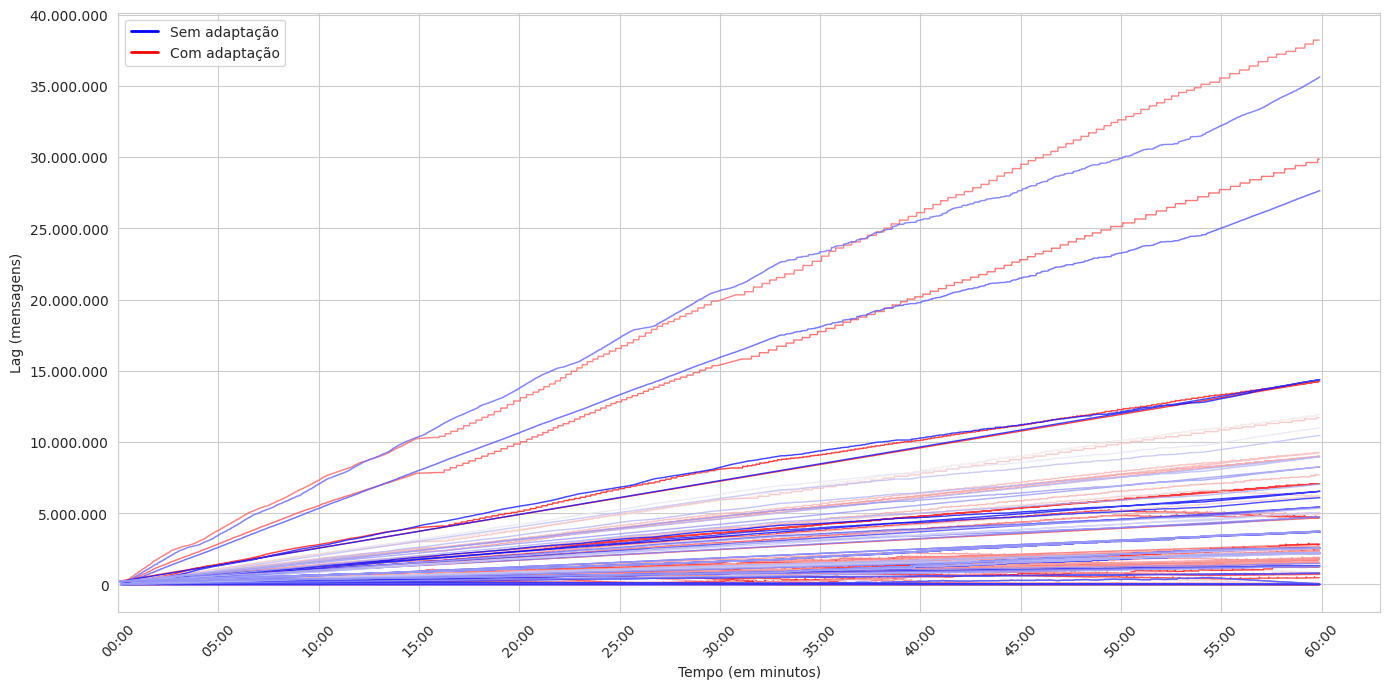

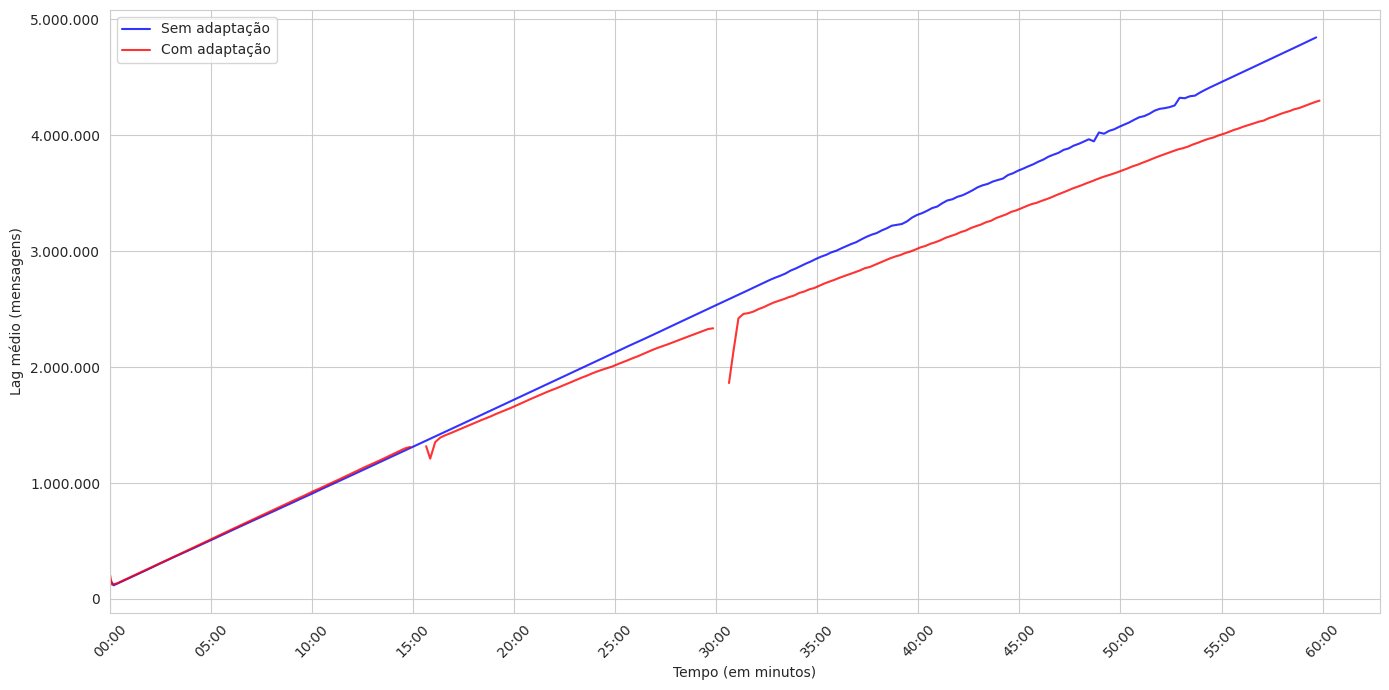

In [4]:
min_groups, max_groups, data = load_data(base_path + '/maestro/metric-records-lag-*',
                                         base_path + '/vanilla/metric-records-lag-*')
plot_series(data, min_groups, max_groups, True, "Lag por Partições",                                      "Tempo (em minutos)", "Lag (mensagens)",       "lag-por-particao")
plot_group(data,                                "Lag médio das partições (janela móvel de 15 segundos)" , "Tempo (em minutos)", "Lag médio (mensagens)", "lag-medio")

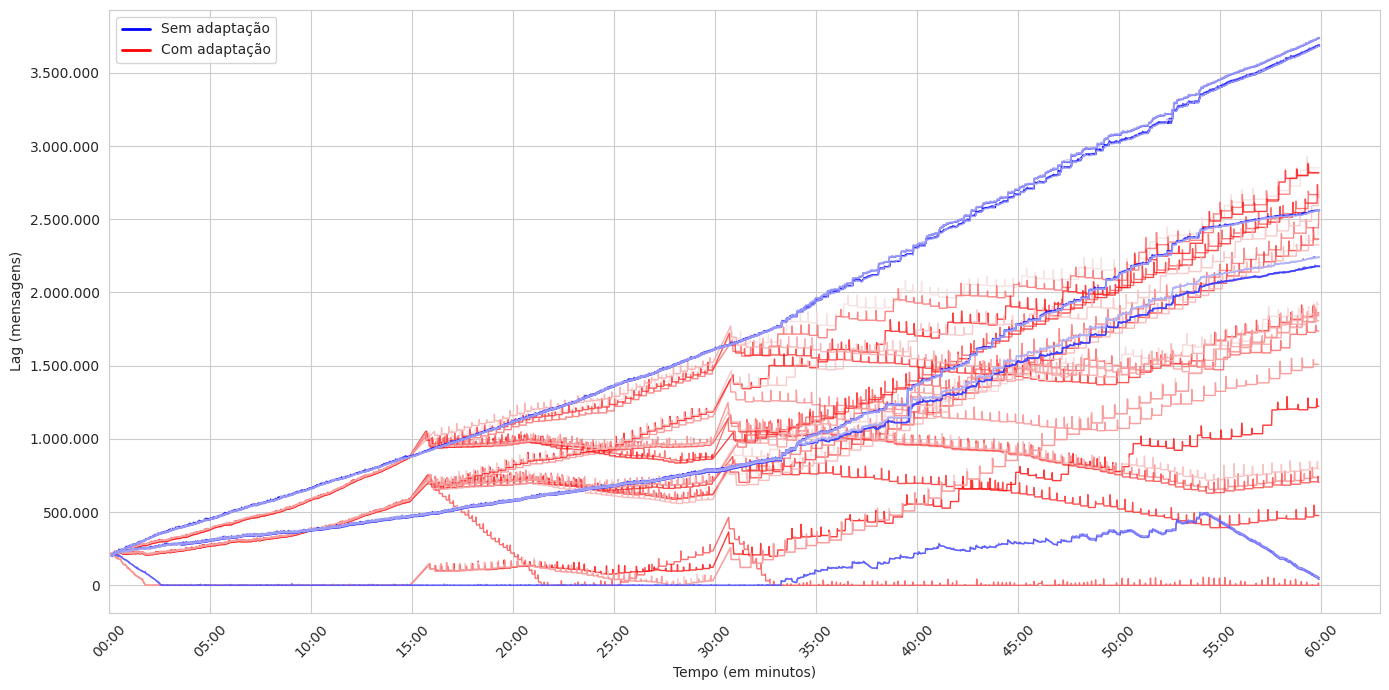

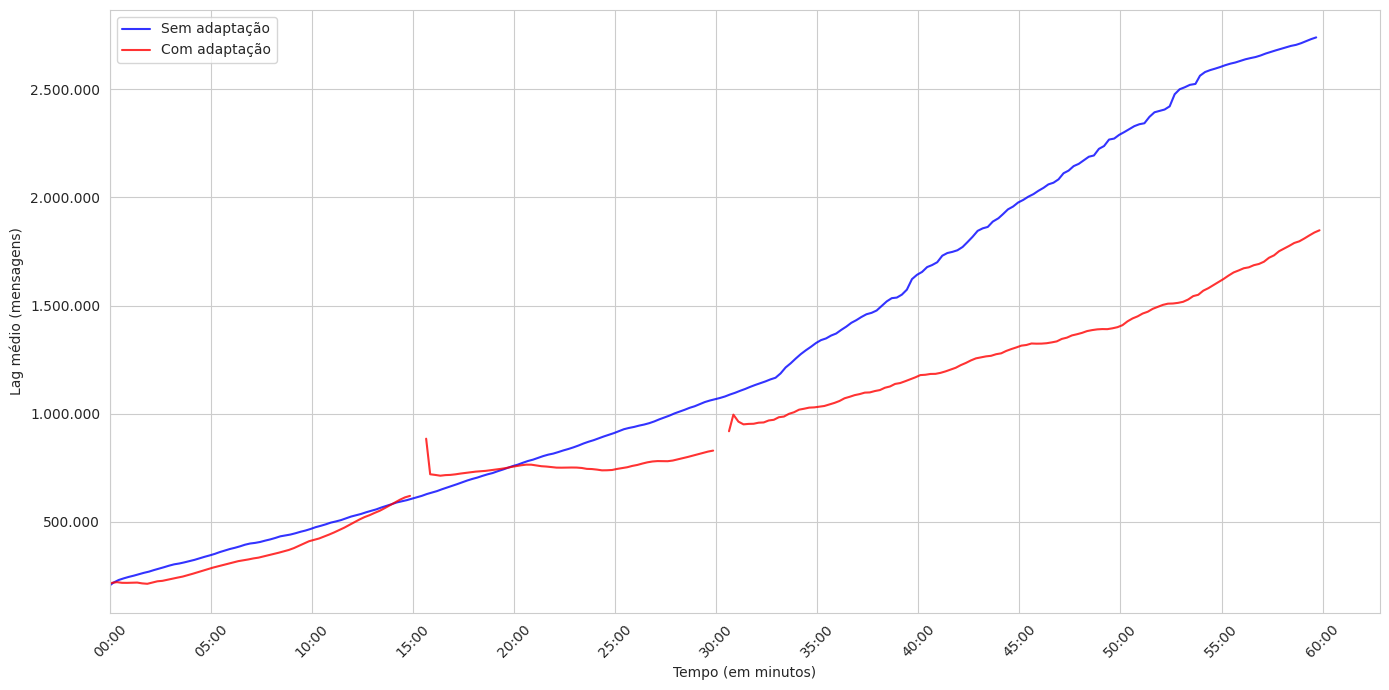

In [5]:
min_groups, max_groups, data = load_data(base_path + '/maestro/metric-records-lag-nyc-taxi-trips-*',
                                         base_path + '/vanilla/metric-records-lag-nyc-taxi-trips-*')
plot_series(data, min_groups, max_groups, True, "Lag por Partições",                                      "Tempo (em minutos)", "Lag (mensagens)",       "lag-entrada-por-particao")
plot_group(data,                                "Lag médio das partições (janela móvel de 15 segundos)" , "Tempo (em minutos)", "Lag médio (mensagens)", "lag-entrada-medio")

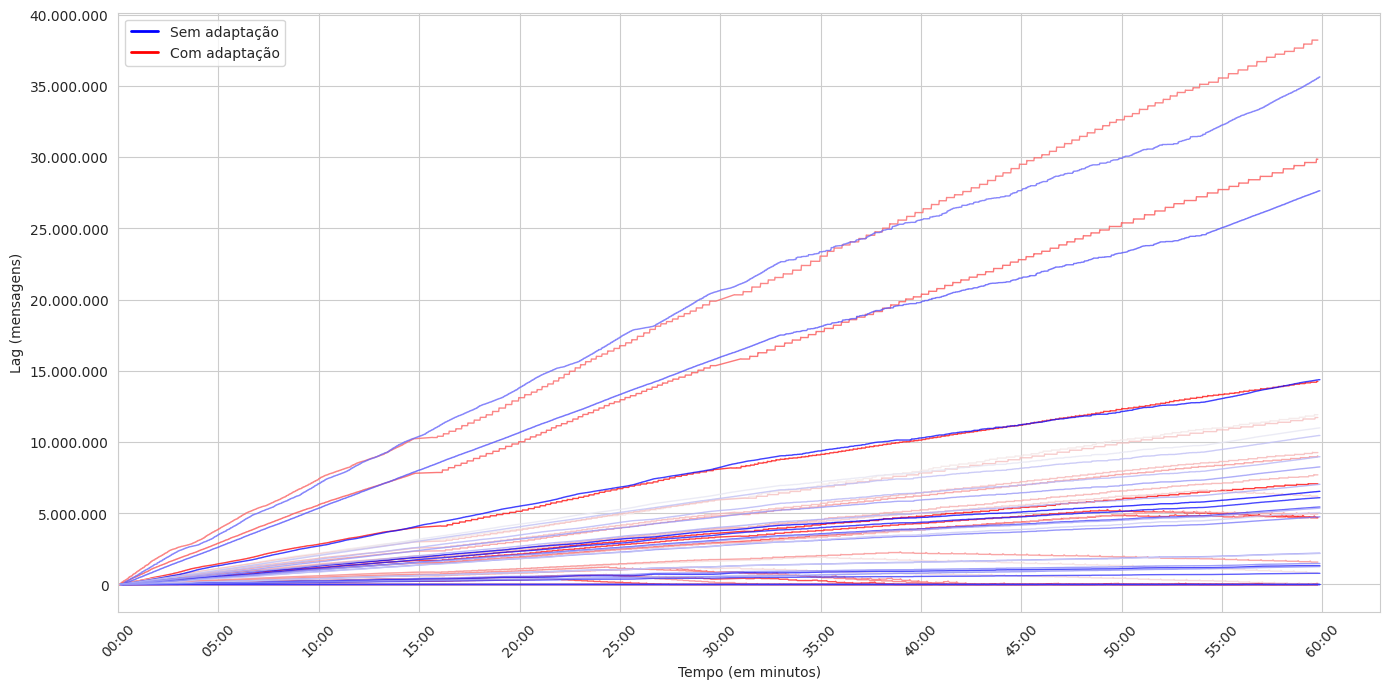

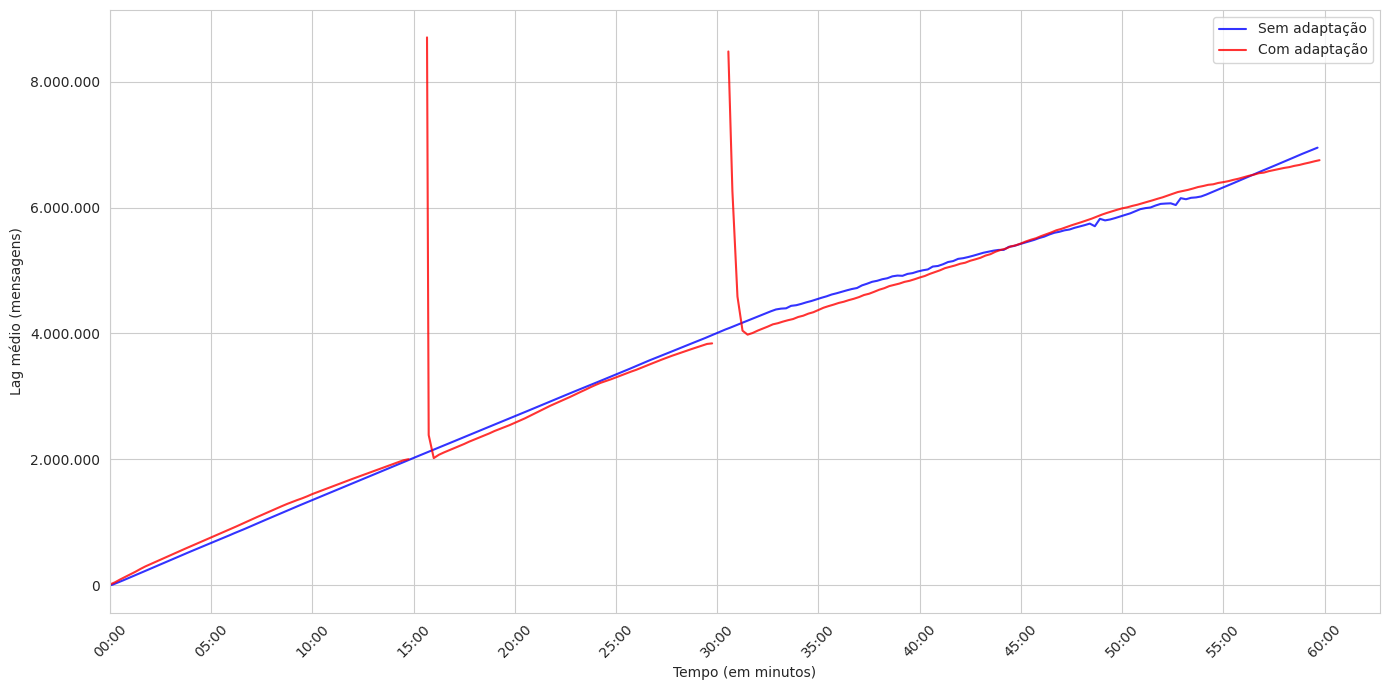

In [6]:
min_groups, max_groups, data = load_data(base_path + '/maestro/metric-records-lag-streams-*',
                                         base_path + '/vanilla/metric-records-lag-streams-*')
plot_series(data, min_groups, max_groups, True, "Lag por Partições",                                      "Tempo (em minutos)", "Lag (mensagens)",       "lag-reparticao-por-particao")
plot_group(data,                                "Lag médio das partições (janela móvel de 15 segundos)" , "Tempo (em minutos)", "Lag médio (mensagens)", "lag-reparticao-medio")

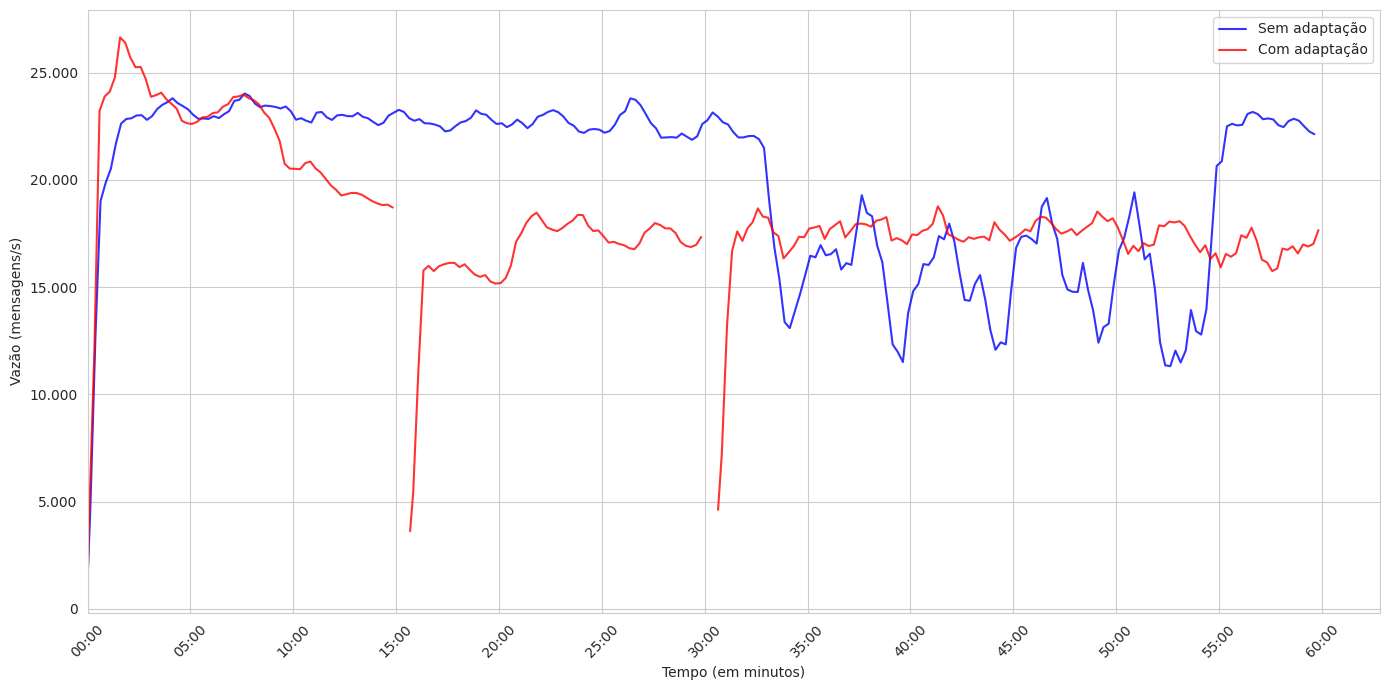

In [7]:
min_groups, max_groups, data = load_data(base_path + '/maestro/metric-records-consumed-rate-*',
                                         base_path + '/vanilla/metric-records-consumed-rate-*')

# plot_series(data, min_groups, max_groups, False, "Vazão de consumo por thread", "Tempo (em minutos)", "Vazão (mensagens/s)", "vazao-consumo-por-thread")
plot_group(data, 'Vazão média de consumo (janela móvel de 15 segundos)'       , "Tempo (em minutos)", "Vazão (mensagens/s)", "vazao-consumo-media")

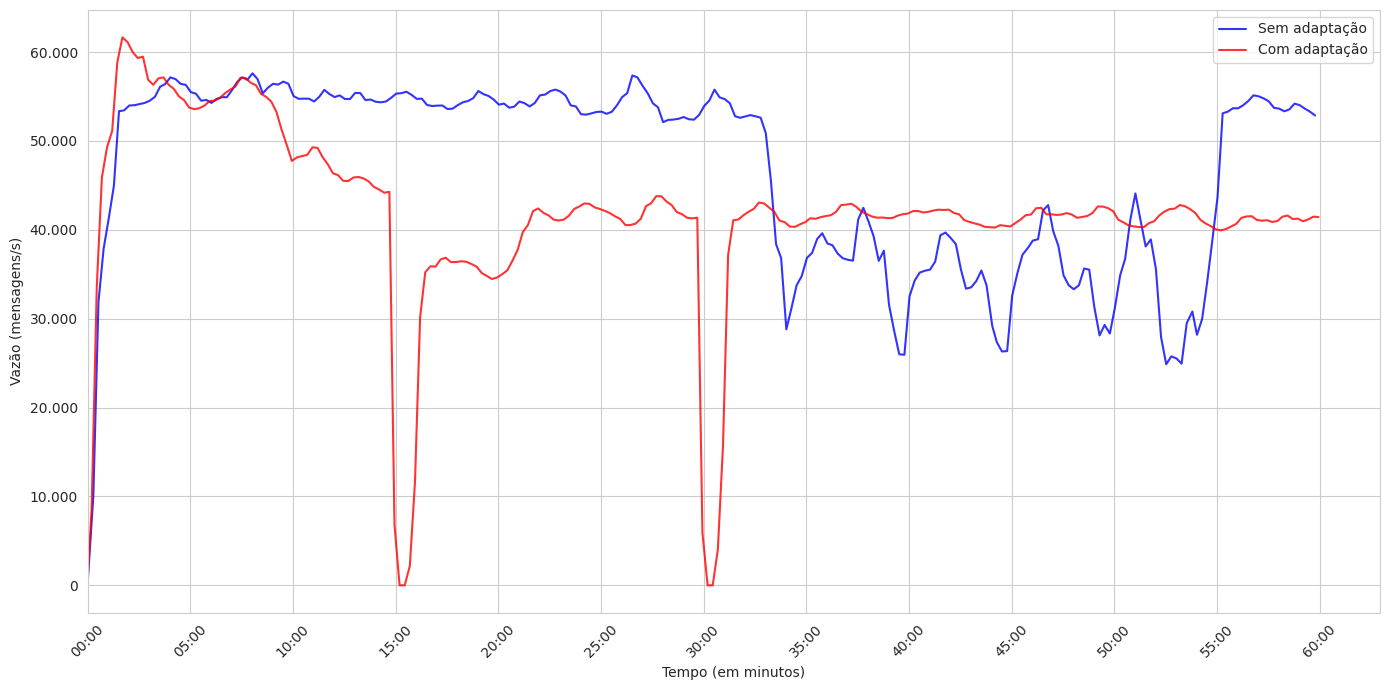

In [8]:
min_groups, max_groups, data = load_data(base_path + '/maestro/metric-record-send-rate-*',
                                         base_path + '/vanilla/metric-record-send-rate-*')

# plot_series(data, min_groups, max_groups, False, "Vazão de produção por thread", "Tempo (em minutos)", "Vazão (mensagens/s)", "vazao-producao-por-thread")
plot_group(data, 'Vazão média de producao (janela móvel de 15 segundos)'       , "Tempo (em minutos)", "Vazão (mensagens/s)", "vazao-producao-media")

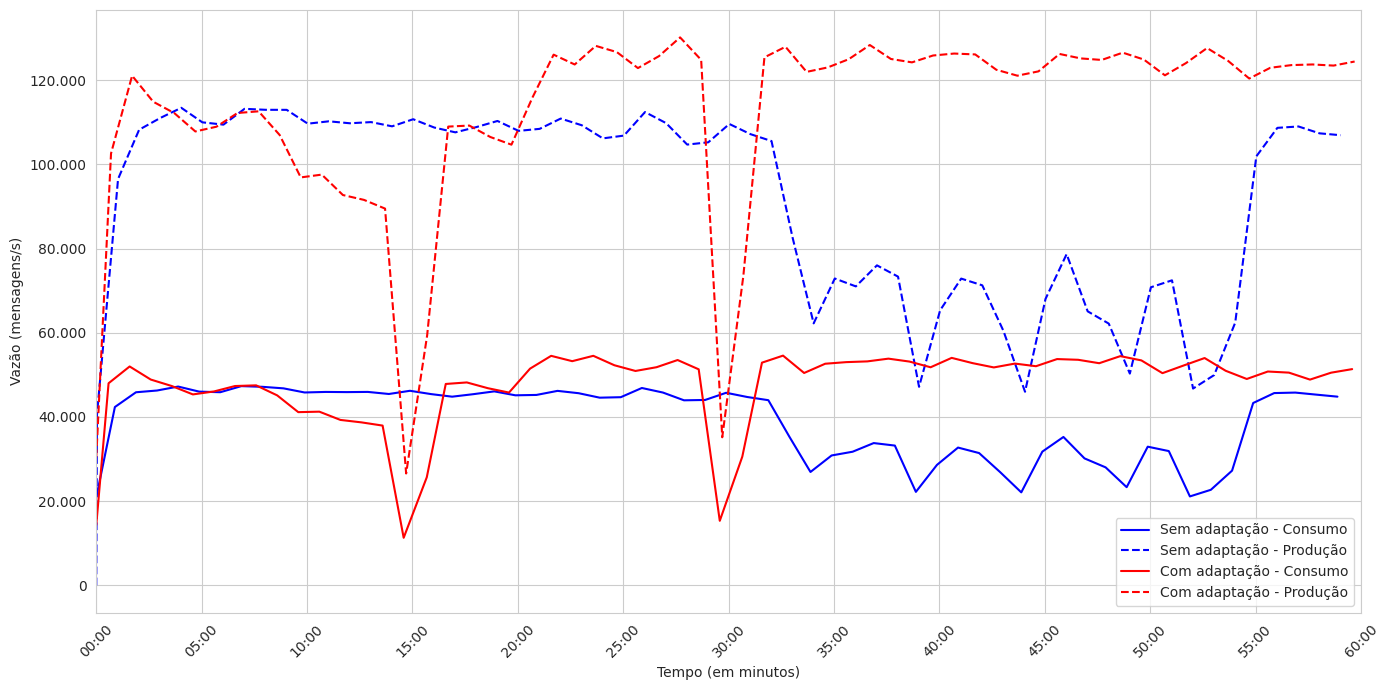

In [9]:
min_groups, max_groups, df_entrada = load_data(base_path + '/maestro/metric-records-consumed-rate-*', 
                                               base_path + '/vanilla/metric-records-consumed-rate-*')
min_groups, max_groups, df_saida   = load_data(base_path + '/maestro/metric-record-send-rate-*', 
                                               base_path + '/vanilla/metric-record-send-rate-*')

plt.figure(figsize=(14, 7))
sns.set_style("whitegrid")

def aggregate_data(df):
    df = df.sort_values('Timestamp_Index').set_index('Timestamp_Index')    
    df = df.groupby('series').resample('1s').agg({
        'Value': 'mean',
        'elapsed_milliseconds': 'first'
    }).reset_index()
    
    return df.groupby('Timestamp_Index').agg({
        'Value': 'sum',
        'elapsed_milliseconds': 'first'  # mantém o elapsed do primeiro registro
    }).resample('60s').agg({
        'Value': 'mean',
        'elapsed_milliseconds': 'first'
    })

df_vanilla_entrada = aggregate_data(df_entrada[df_entrada['source'] == 'vanilla'])
df_maestro_entrada = aggregate_data(df_entrada[df_entrada['source'] == 'maestro'])

df_vanilla_saida = aggregate_data(df_saida[df_saida['source'] == 'vanilla'])
df_maestro_saida = aggregate_data(df_saida[df_saida['source'] == 'maestro'])

ax = plt.gca()
plt.xlim(left=0)

plt.xlabel("Tempo (em minutos)")
plt.ylabel("Vazão (mensagens/s)")
    
# Cria marcações de 5 minutos (300,000 ms) 
max_x = max(df_vanilla_entrada['elapsed_milliseconds'].max(), 
            df_maestro_entrada['elapsed_milliseconds'].max(),
            df_vanilla_saida['elapsed_milliseconds'].max(),
            df_maestro_saida['elapsed_milliseconds'].max())
xticks = list(range(0, int(max_x) + 300000, 300000))  # Marcas a cada 5 min

# Define as marcações e rótulos do eixo X
plt.xticks(xticks, [format_seconds(x, None) for x in xticks], rotation=45)
ax.yaxis.set_major_formatter(FuncFormatter(format_number))

plt.plot(df_vanilla_entrada['elapsed_milliseconds'], df_vanilla_entrada['Value'], color='blue',  linestyle='-',  label='Sem adaptação - Consumo')
plt.plot(df_vanilla_saida['elapsed_milliseconds'],   df_vanilla_saida['Value'],   color='blue',  linestyle='--', label='Sem adaptação - Produção')
plt.plot(df_maestro_entrada['elapsed_milliseconds'], df_maestro_entrada['Value'], color='red', linestyle='-',  label='Com adaptação - Consumo')
plt.plot(df_maestro_saida['elapsed_milliseconds'],   df_maestro_saida['Value'],   color='red', linestyle='--', label='Com adaptação - Produção')

plt.legend(loc='lower right')
plt.tight_layout()
plt.savefig(f'./imagens/vazao-total.png', bbox_inches="tight")
plt.show()

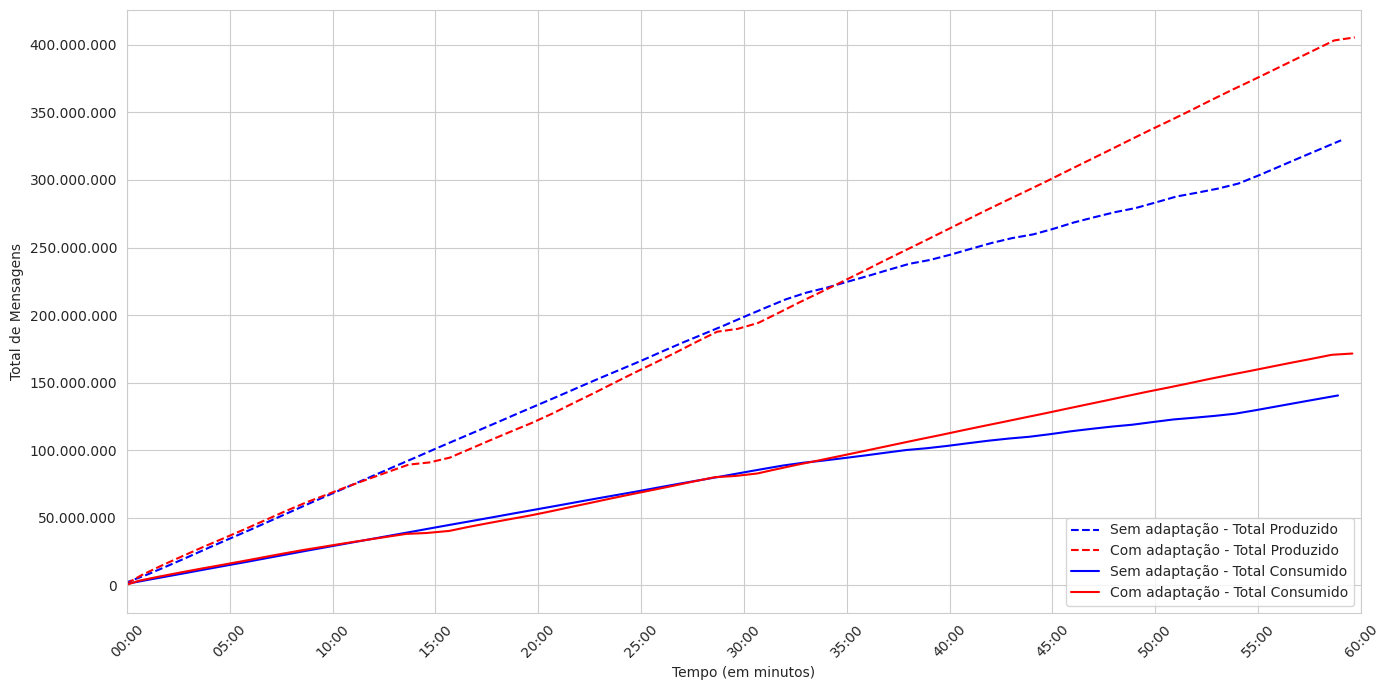

In [10]:
min_groups, max_groups, df_entrada = load_data(base_path + '/maestro/metric-records-consumed-rate-*', 
                                               base_path + '/vanilla/metric-records-consumed-rate-*')
min_groups, max_groups, df_saida = load_data(base_path + '/maestro/metric-record-send-rate-*', 
                                             base_path + '/vanilla/metric-record-send-rate-*')

plt.figure(figsize=(14, 7))
sns.set_style("whitegrid")

def calculate_total_messages(df):
    df = df.sort_values('Timestamp_Index').set_index('Timestamp_Index')    
    
    # Group by series and resample to 1 second to get rate per second
    df_resampled = df.groupby('series').resample('1s').agg({
        'Value': 'mean',  # messages per second rate
        'elapsed_milliseconds': 'first'
    }).reset_index()
    
    # Sum the rates across all series to get total rate per second
    df_total_rate = df_resampled.groupby('Timestamp_Index').agg({
        'Value': 'sum',  # total messages per second
        'elapsed_milliseconds': 'first'
    })
    
    # Calculate cumulative sum to get total messages over time
    df_total_rate['cumulative_messages'] = df_total_rate['Value'].cumsum()
    
    # Resample to 60 seconds, taking the last cumulative value
    df_final = df_total_rate.resample('60s').agg({
        'cumulative_messages': 'last',
        'elapsed_milliseconds': 'first'
    })
    
    return df_final

df_vanilla_consumed = calculate_total_messages(df_entrada[df_entrada['source'] == 'vanilla'])
df_maestro_consumed = calculate_total_messages(df_entrada[df_entrada['source'] == 'maestro'])
df_vanilla_produced = calculate_total_messages(df_saida[df_saida['source'] == 'vanilla'])
df_maestro_produced = calculate_total_messages(df_saida[df_saida['source'] == 'maestro'])

ax = plt.gca()
plt.xlim(left=0)

plt.xlabel("Tempo (em minutos)")
plt.ylabel("Total de Mensagens")

# Cria marcações de 5 minutos (300,000 ms) 
max_x = max(df_vanilla_produced['elapsed_milliseconds'].max(), 
            df_maestro_produced['elapsed_milliseconds'].max(),
            df_vanilla_consumed['elapsed_milliseconds'].max(),
            df_maestro_consumed['elapsed_milliseconds'].max())
xticks = list(range(0, int(max_x) + 300000, 300000))  # Marcas a cada 5 min

# Define as marcações e rótulos do eixo X
plt.xticks(xticks, [format_seconds(x, None) for x in xticks], rotation=45)
ax.yaxis.set_major_formatter(FuncFormatter(format_number))

plt.plot(df_vanilla_produced['elapsed_milliseconds'], df_vanilla_produced['cumulative_messages'], color='blue', linestyle='--', label='Sem adaptação - Total Produzido')
plt.plot(df_maestro_produced['elapsed_milliseconds'], df_maestro_produced['cumulative_messages'],  color='red', linestyle='--', label='Com adaptação - Total Produzido')
plt.plot(df_vanilla_consumed['elapsed_milliseconds'], df_vanilla_consumed['cumulative_messages'], color='blue', linestyle='-', label='Sem adaptação - Total Consumido')
plt.plot(df_maestro_consumed['elapsed_milliseconds'], df_maestro_consumed['cumulative_messages'],  color='red', linestyle='-', label='Com adaptação - Total Consumido')

plt.legend(loc='lower right')
plt.tight_layout()
plt.savefig(f'./imagens/total-mensagens-produzidas.png', bbox_inches="tight")
plt.show()

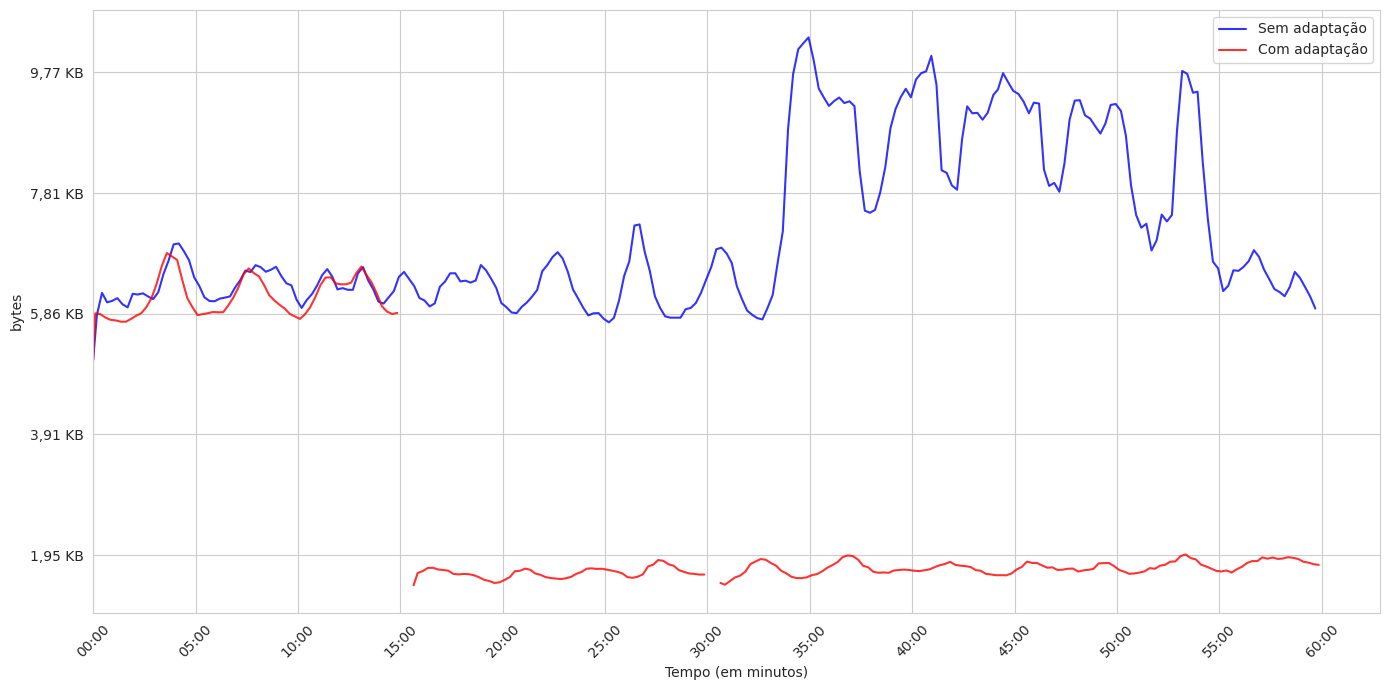

In [11]:
min_groups, max_groups, data = load_data(base_path + '/maestro/metric-batch-size-avg-*',
                                         base_path + '/vanilla/metric-batch-size-avg-*')

# plot_series(data, min_groups, max_groups, True, "Taxa de compressão por thread", "Tempo (em minutos)", "Percentual de Compressão de Mensagens (%)", "compression-rate-por-thread")
plot_group(data, "Tamanho médio do lote", "Tempo (em minutos)", "bytes", "compression-rate-por-thread", memoria=True)

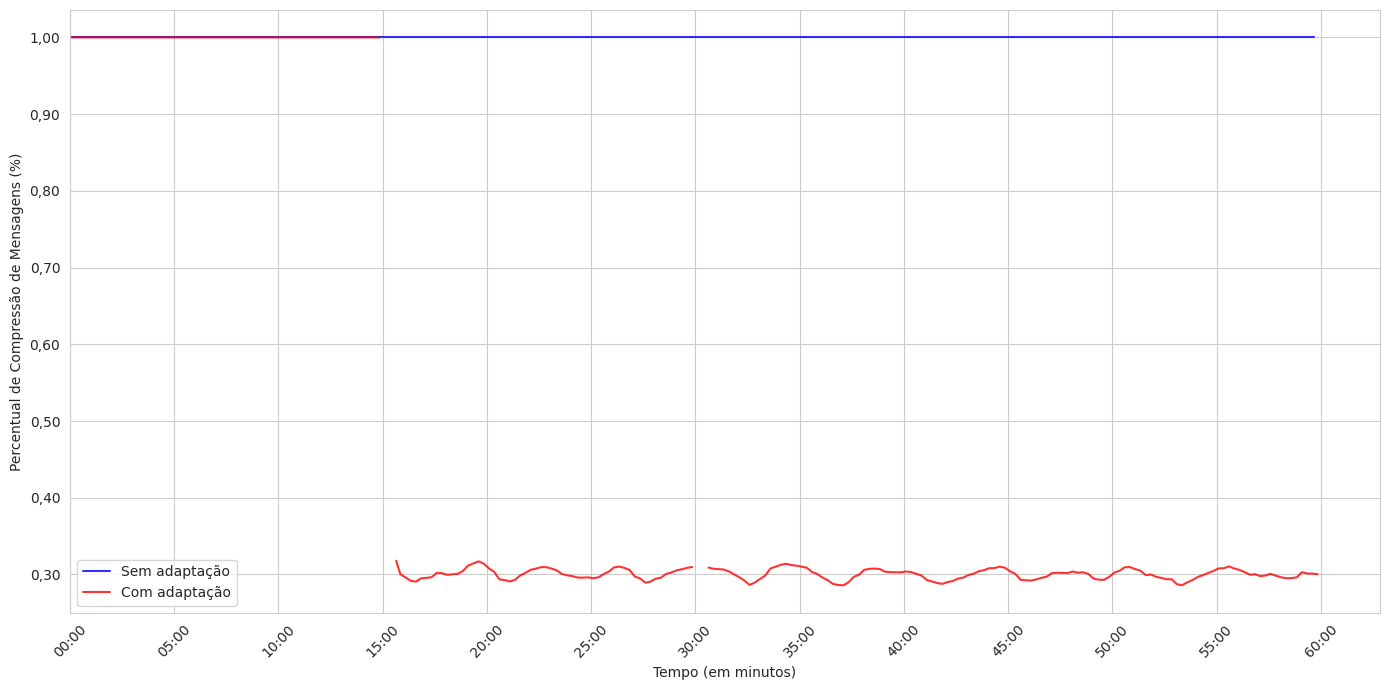

In [12]:
min_groups, max_groups, data = load_data(base_path + '/maestro/metric-compression-rate-avg-*',
                                         base_path + '/vanilla/metric-compression-rate-avg-*')

# plot_series(data, min_groups, max_groups, True, "Taxa de compressão por thread", "Tempo (em minutos)", "Percentual de Compressão de Mensagens (%)", "compression-rate-por-thread")
plot_group(data, "Taxa de compressão por thread", "Tempo (em minutos)", "Percentual de Compressão de Mensagens (%)", "compression-rate-por-thread")

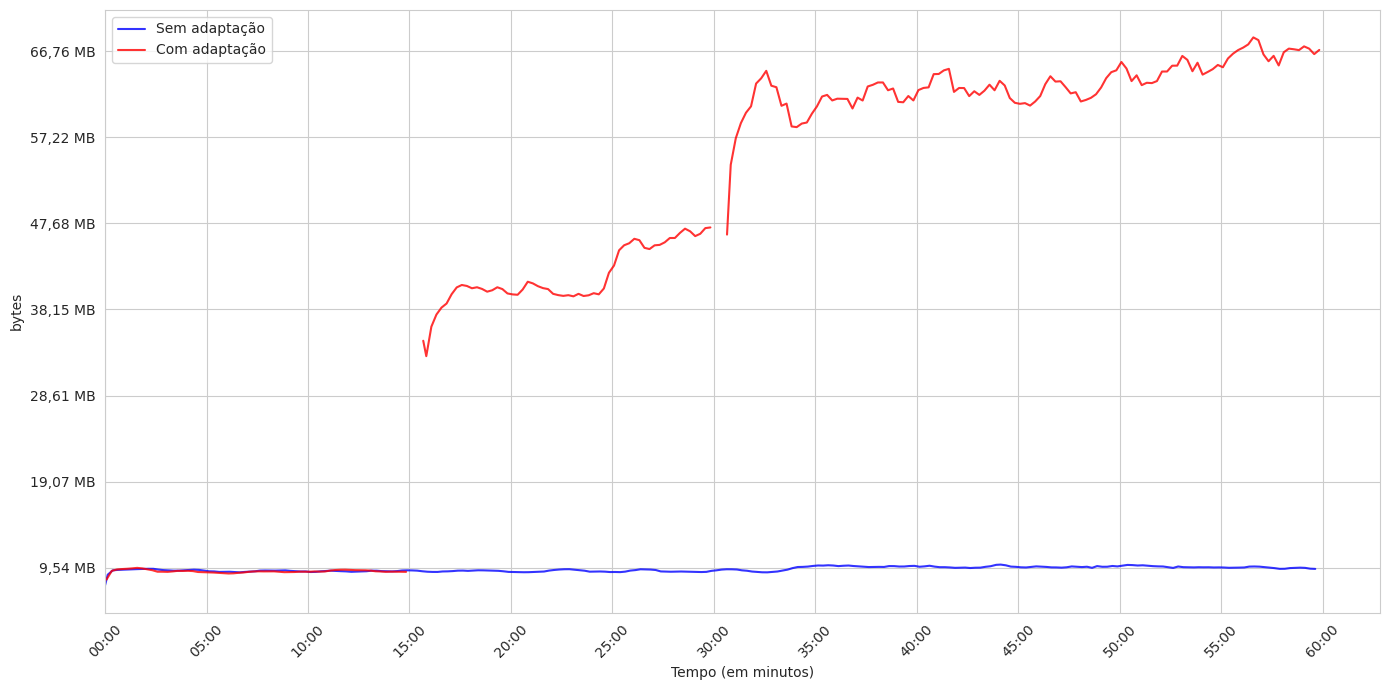

In [13]:
min_groups, max_groups, data = load_data(base_path + '/maestro/metric-fetch-size-avg-*',
                                         base_path + '/vanilla/metric-fetch-size-avg-*')

# plot_series(data, min_groups, max_groups, True, "Tamanho Médio do Fetch por Thread", "Tempo (em minutos)", "bytes", "fetch-por-thread", memoria=True)
plot_group(data, 'Tamanho Médio do Fetch (janela móvel de 15 segundos)' ,            "Tempo (em minutos)", "bytes", "fetch-medio", memoria=True)

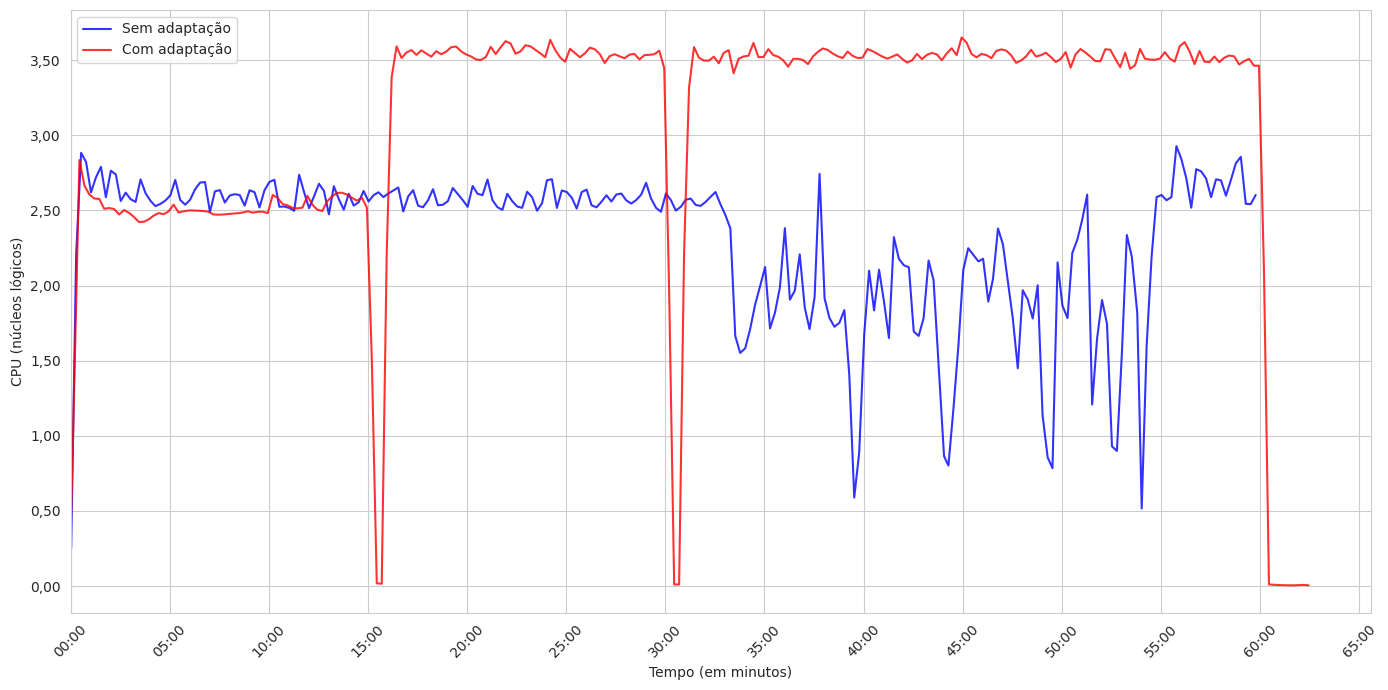

In [14]:
min_groups, max_groups, data = load_data(base_path + '/maestro/metric-cpu-used*',
                                         base_path + '/vanilla/metric-cpu-used*')

plot_group(data, 'Uso de CPU' , "Tempo (em minutos)", "CPU (núcleos lógicos)", "uso-cpu")

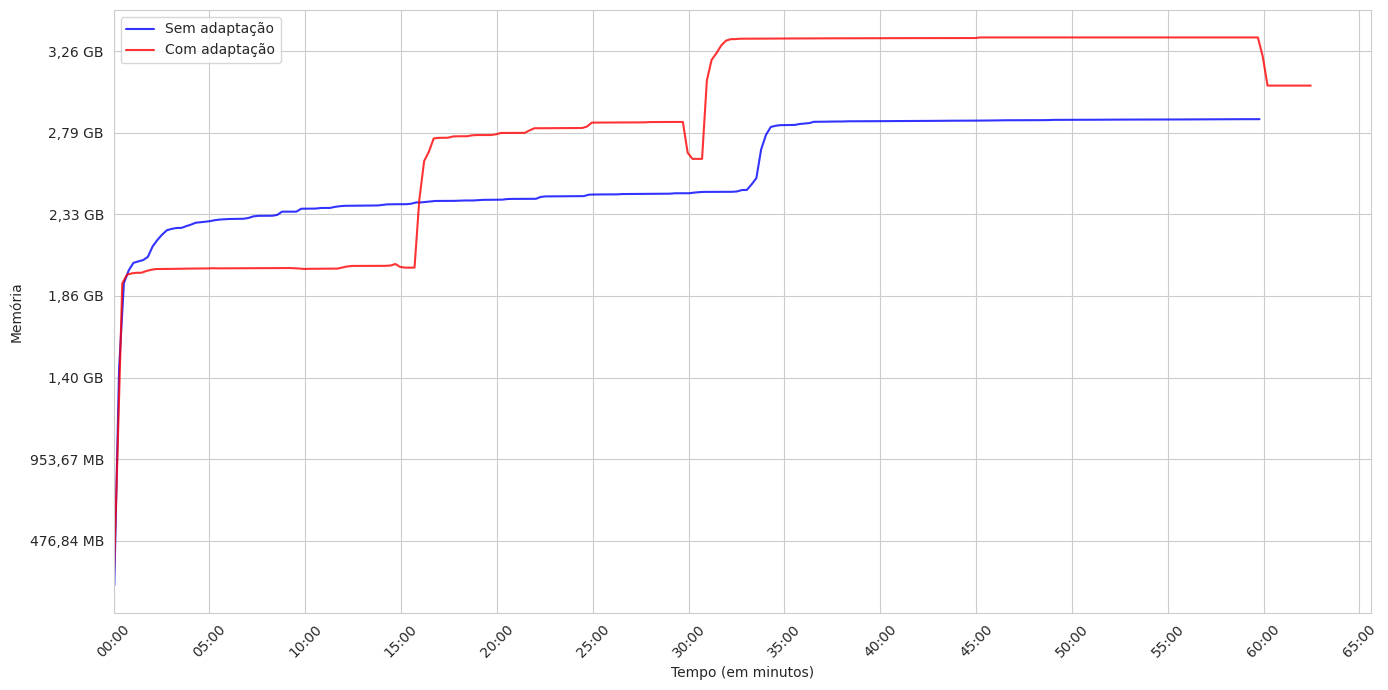

In [15]:
min_groups, max_groups, data = load_data(base_path + '/maestro/metric-memory-used*',
                                         base_path + '/vanilla/metric-memory-used*')

plot_group(data, 'Uso de Memória' , "Tempo (em minutos)", "Memória", "uso-memoria", memoria=True)

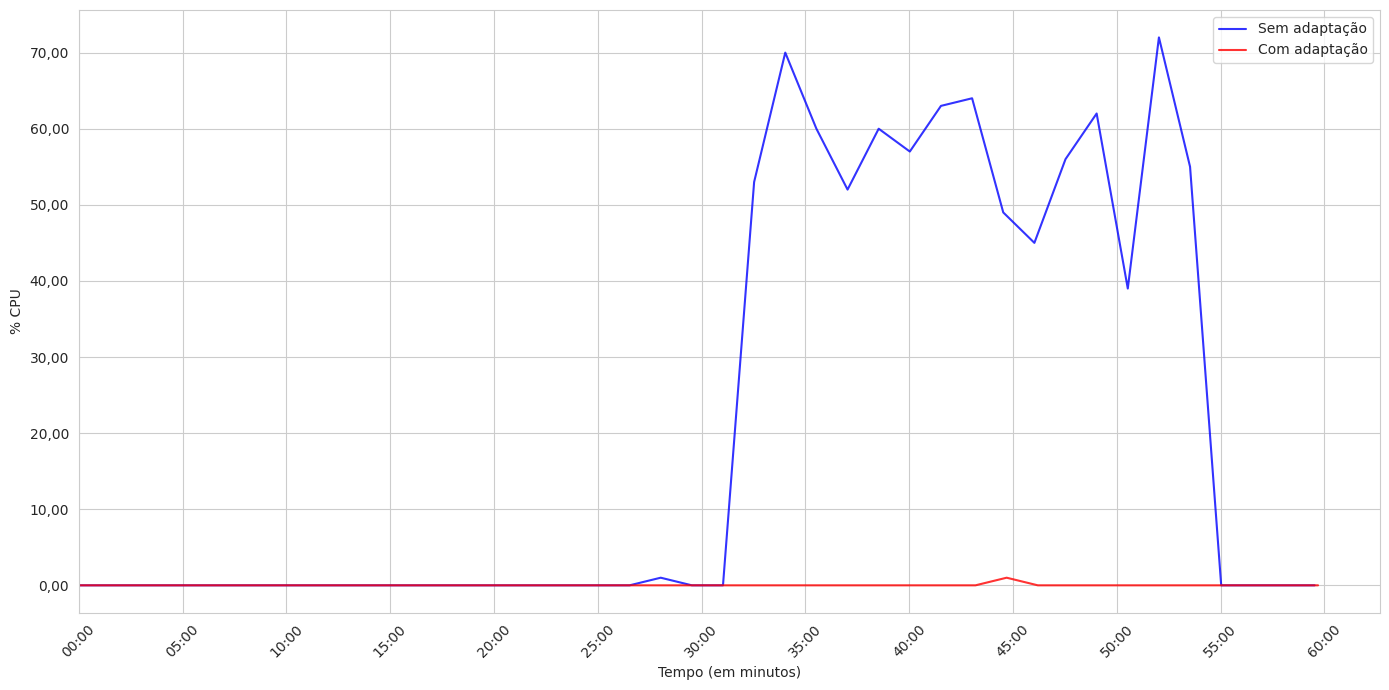

In [16]:
min_groups, max_groups, data = load_data(base_path + '/maestro/metric-waiting-threads-*',
                                         base_path + '/vanilla/metric-waiting-threads-*')

# plot_series(data, min_groups, max_groups, True, "Threads bloqueadas", "Tempo (em minutos)", "% CPU", "fetch-por-thread")
plot_group(data, 'Threads bloqueadas(janela móvel de 15 segundos)' ,            "Tempo (em minutos)", "% CPU", "waiting-threads", window='90s', agg='sum')

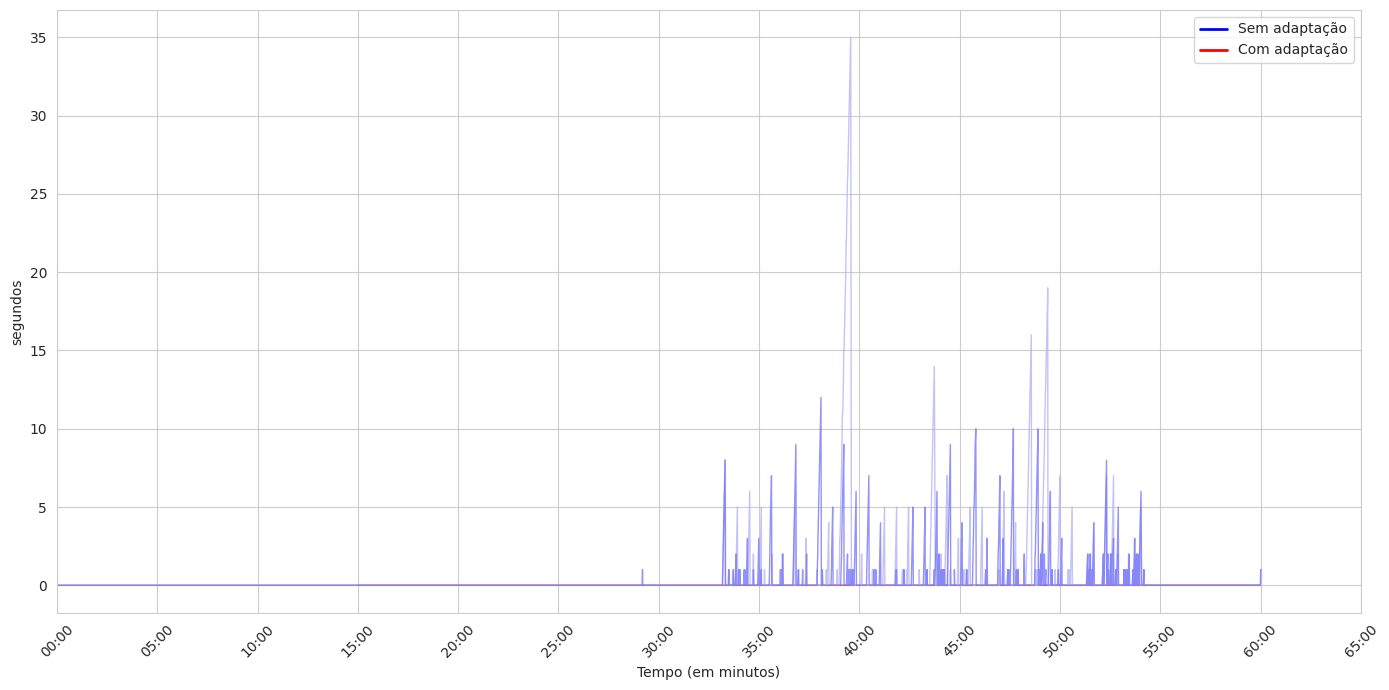

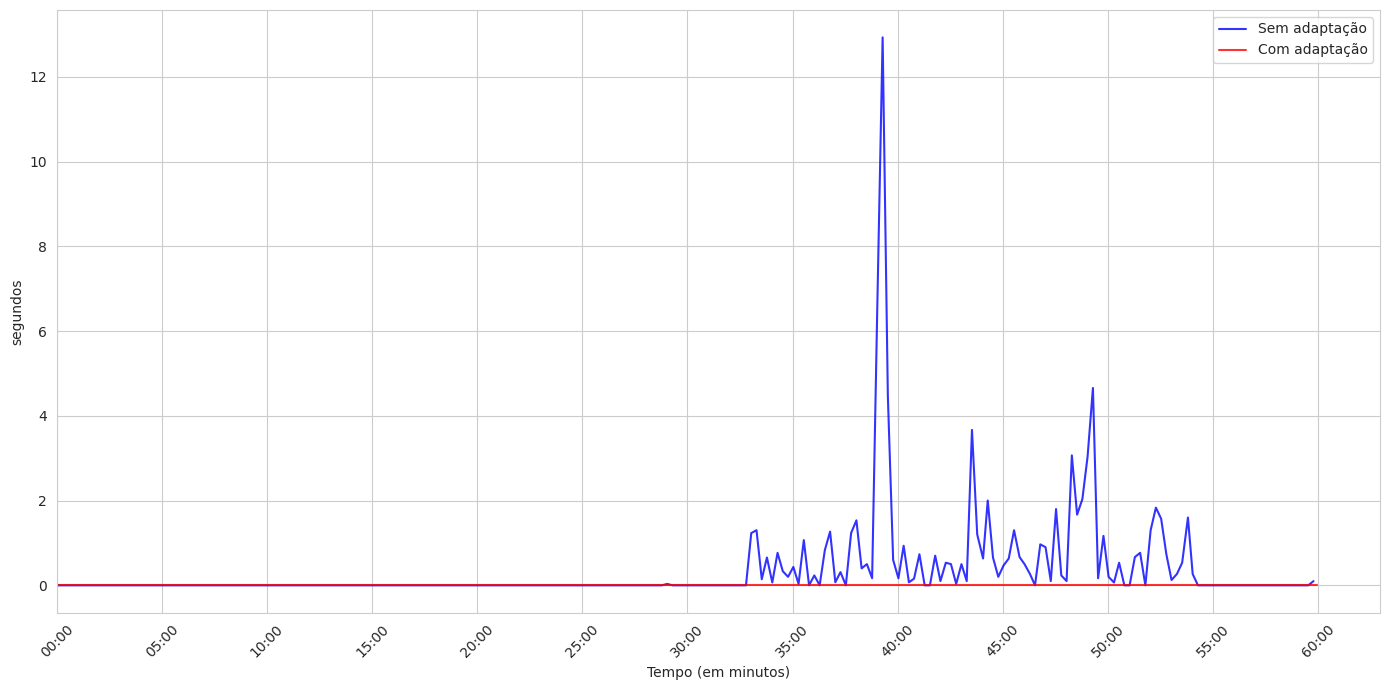

In [17]:
min_groups, max_groups, data = load_data(base_path + '/maestro/metric-last-poll-seconds-ago-*',
                                         base_path + '/vanilla/metric-last-poll-seconds-ago-*')

plot_series(data, min_groups, max_groups, True, "Threads bloqueadas", "Tempo (em minutos)", "segundos", "last-poll-por-thread")
plot_group(data, 'Threads bloqueadas(janela móvel de 15 segundos)' ,            "Tempo (em minutos)", "segundos", "last-poll")